In [144]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import math 
from collections import namedtuple

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [309]:
configV2 = {
    "dryMass": 4000,
    "w": 2050,  # m/s
    "Gsm": 127, # kg/s
    "fuelMass": 8355,
    "Fc": (1.04 ** 2) * np.pi,
    "Pc": 0.9 * (10 ** 5),
    "jetStearingLoss": 0.97,
    "Cf": 0.06,
    "V": 12 * (0.85 ** 2) * np.pi,
}

configMini = {
    "dryMass": 90, # 4000 / 8,
    "w": 2050,  # m/s
    "Gsm": 127 / 30, # kg/s
    "fuelMass": 400, #8355 / 8,
    "Fc": (1.04 ** 2) * np.pi / 4,
    "Pc": 0.9 * (10 ** 5),
    "jetStearingLoss": 0.97,
    "Cf": 0.04,
    "V": 6 * (0.3 ** 2) * np.pi,
}

rocketConfig = namedtuple("V2", configV2.keys())(*configV2.values()) 

In [295]:
(rocketConfig.w ** 2) * rocketConfig.fuelMass / 10**6 / 2
#calcAll()

17555.94375

In [299]:
def gravitation(x):
#    return 9.8
    M = 5.972e+24
    G = 6.67408e-11
    r = 6371000

    return G * M / ((r + x) ** 2)
            

def temperatureC(x):
    # https://meteoinfo.ru/about/glossary/4806-2012-03-11-20-40-41
    if x < 8000: return -4 * x / 1000
    if x < 25000: return -56
    if x < 40000: return -56 + 57 / 15 * (x / 1000 - 25)
    if x < 50000: return 0
    
    return max(0 -3 * (x - 50000) / 1000, -100)
    

def calcAtmosphericPressure(x):
    # https://planetcalc.ru/938/
    # https://tehtab.ru/Guide/GuidePhysics/GuidePhysicsPressure/AirPressureHeight/
    
    mercury2pascal = 133.3224
    p0 = 760
    temperatureK = temperatureC(x) + 274
    mu = 0.029
    g = gravitation(x)
    R = 8.31
    
#    return 0
    return p0 * np.exp(-mu * g * x / (R * temperatureK)) * mercury2pascal
    

def calcAtmosphericDensity(x):
    # https://tehtab.ru/Guide/GuidePhysics/GuidePhysicsDensity/DensityAirHeight/
    temperatureK = temperatureC(x) + 274
    mu = 0.029
    g = gravitation(x)
    R = 8.31
    return mu * calcAtmosphericPressure(x) / (temperatureK * R)

def calcFueldMass(t):    
    return max(0, rocketConfig.fuelMass - rocketConfig.Gsm * t)

def calcTotalMass(t):
    return calcFueldMass(t) + rocketConfig.dryMass

def reactiveForce(t, x): # x - height (meters)
    w = rocketConfig.w    # m/s
    Gsm = rocketConfig.Gsm
    Fc = rocketConfig.Fc
    g = gravitation(x)
    P0 = calcAtmosphericPressure(x) / g
    Pc = rocketConfig.Pc / g
    jetStearingLoss = rocketConfig.jetStearingLoss
    
    if calcFueldMass(t) == 0: return 0
    
    return (Gsm / g * w + Fc * (Pc - P0) / g)  * jetStearingLoss * g

print(0, reactiveForce(65, 0))
print(1000, reactiveForce(65, 1000))
print(10000, reactiveForce(65, 10000))
print(100000, reactiveForce(65, 100000))

def atmosphericDrag(x, v): # x - height (meters), v - velocity (m/s)
    Cf = rocketConfig.Cf
    V = rocketConfig.V
    
    return Cf * calcAtmosphericDensity(x) * (v ** 2) * (V ** (2/3)) / 2


0 248738.20635470987
1000 252790.95802434007
10000 275724.22222204384
100000 283704.1594115996


In [300]:
def forcesIntegrand(t, step, v, x): # t - sec, v = m/s, x - meters
    reactive = reactiveForce(t, x)
    force = reactive - math.copysign(atmosphericDrag(x, v), v)
    
    x_next = step * v + x
    m_next = calcTotalMass(t + step)
    a = force / m_next - gravitation(x)
    v_next = v + step * a
    
    return (x_next, v_next, a, reactive)
    

In [303]:
def simulate(step):
    t = 0
    v = 0
    x0 = 0
    x = 0
    
    allX = [x]
    allV = [v]
    allDensity = [calcAtmosphericDensity(x)]
    allPressure = [calcAtmosphericPressure(x)]
    allDrag = [atmosphericDrag(x, v)]
    allA = [0]
    
    allT = [t]
    
    r = 0
    
    while t < 0.1 or x > x0:
        (x_next, v_next, a, reactive) = forcesIntegrand(t, step, v, x)
        v = v_next
        x = x_next
        r += reactive * step
        
        allX.append(x)
        allV.append(v)
        allDensity.append(calcAtmosphericDensity(x))
        allPressure.append(calcAtmosphericPressure(x))
        allDrag.append(atmosphericDrag(x, v))
        allT.append(t)
        allA.append(a)
        
        t += step
    
    print("Integral reaction:", r)
    return (allT, allX, allV, allDensity, allPressure, allDrag, allA)

Integral reaction: 17623151.89294231
1612.399245625918 5199.662654590059 0.04357015799053175


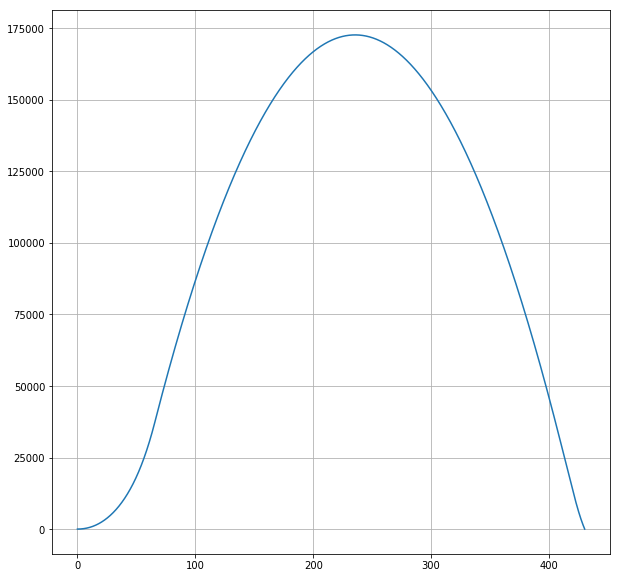

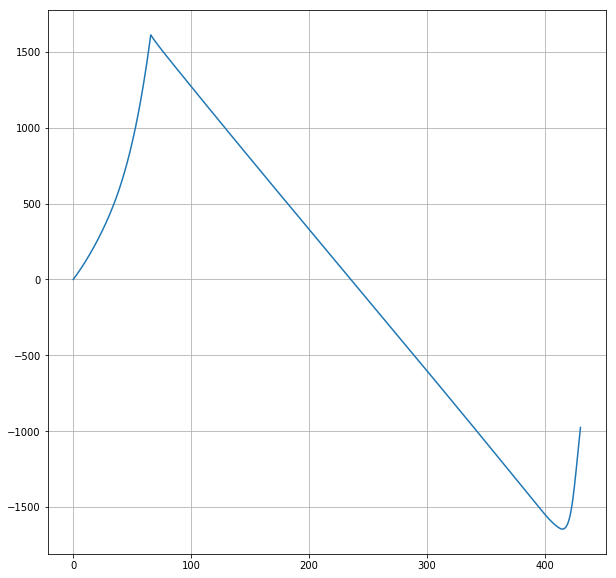

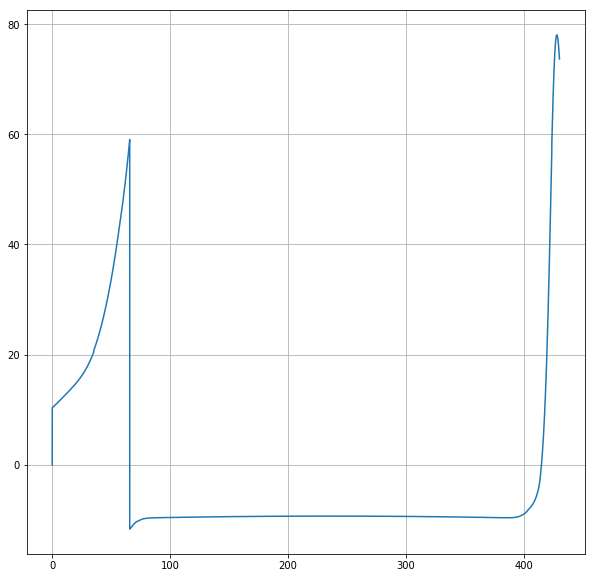

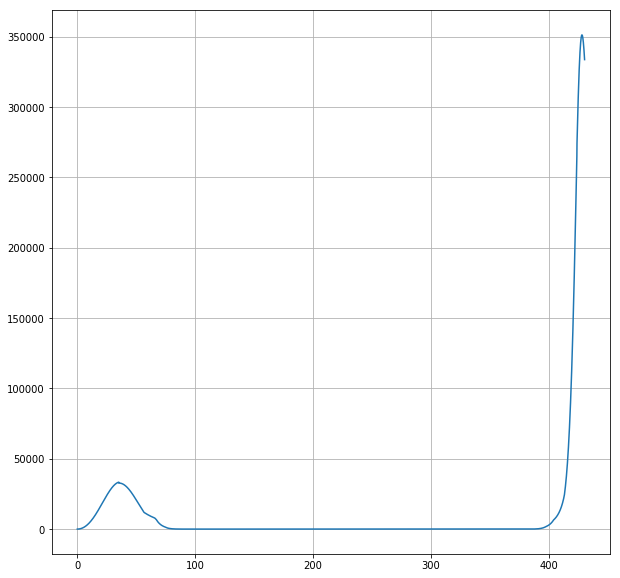

In [310]:
def calcAll():
    (allT, allX, allV, allDensity, allPressure, allDrag, allA) = simulate(0.01)
    
    maxV = np.max(allV)
    e = maxV * maxV * rocketConfig.dryMass / 2 / 10**6
    kpi = e / (3900 * 30.6)
    print(maxV, e, kpi)

    fig, ax = plt.subplots()
    p1, = ax.plot(allT, allX, label="Height")
    ax.grid()
    plt.show()


    fig2, ax2 = plt.subplots()
    p2, = ax2.plot(allT, allV, label="Velocity")
    ax2.grid()
    plt.show()


    fig3, ax3 = plt.subplots()
    p3 = ax3.plot(allT, allA, label="Acceleration")
    ax3.grid()
    plt.show()

    fig4, ax4 = plt.subplots()
    p4 = ax4.plot(allT, allDrag, label="Drag")
    ax4.grid()
    plt.show()
calcAll()

In [307]:
atmosphericDrag(100, 1000)

346624.14202779654

In [83]:
for x in [0, 0.05, 0.1, 1, 2, 5, 8, 10, 12, 15, 20, 30, 50, 100, 120]:
    print(x, "\t", calcAtmosphericPressure(x * 1000))

0 	 101325.02399999999
0.05 	 100692.99961067642
0.1 	 100064.15930161864
1 	 89276.19004112124
2 	 78413.4039375045
5 	 52074.71756708024
8 	 28902.618073550497
10 	 21143.12175060766
12 	 15472.884355598651
15 	 9693.781195528818
20 	 4455.306495526563
30 	 1378.6912923222797
50 	 214.8098328639201
100 	 2.3536662973406588e-07
120 	 1.3278881886688785e-22


In [104]:
for x in [0, 0.05, 0.1, 1, 2, 5, 8, 10, 12, 15, 20, 30, 50, 100, 120]:

print(x, "\t", calcAtmosphericDensity(x * 1000))

0 	 1.2905152072518378
0.05 	 1.2834014070931399
0.1 	 1.2763160758897667
1 	 1.1535772371968276
2 	 1.0275510802165349
5 	 0.7098649518902203
8 	 0.46267673750701843
10 	 0.33846174652382016
12 	 0.2476918746687206
15 	 0.15517926598347065
20 	 0.07132110553785663
30 	 0.020300917240346952
50 	 0.002735902199027503
100 	 1.0401308244276545e-08
120 	 2.6310435879645943e-10


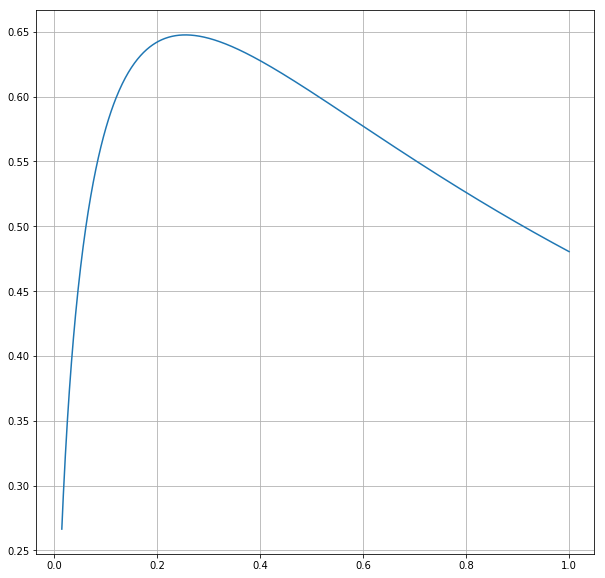

In [296]:
# to calc optimal m/M
x = np.linspace(0.015, 1, 1000)
y = x * np.log((x + 1)/x) ** 2

fig, ax = plt.subplots()
p1, = ax.plot(x, y, label="Height")
ax.grid()
plt.show()
